In [2]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
from gridtools.hypnotoad_tools import *
from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [2]:
path = r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\From\Matteo\2022-07-24 - DTT30MW_6e19\SOLEDGE2D_30MW_6e19_DTT"
from wrapper_class import *

sc = SOLEDGEcase(path)

ModuleNotFoundError: No module named 'wrapper_class'

# Hermes IO

In [3]:
casestore = dict()

In [6]:
db = CaseDB()

toload = [
    dict(name="base", id="d8a-tn_30ev", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="fluxlim", id="d10c-30ev_fluxlim0.2", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="anom_visc", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [10]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [7]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

base
fluxlim
anom_visc
2e19


# Read SOLEDGE CSV data

In [8]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"),
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

## Read SOLPS

In [16]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"C:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\Mike.Kryajak\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\Mike.Krya

In [148]:
%matplotlib inline

# Lineplots

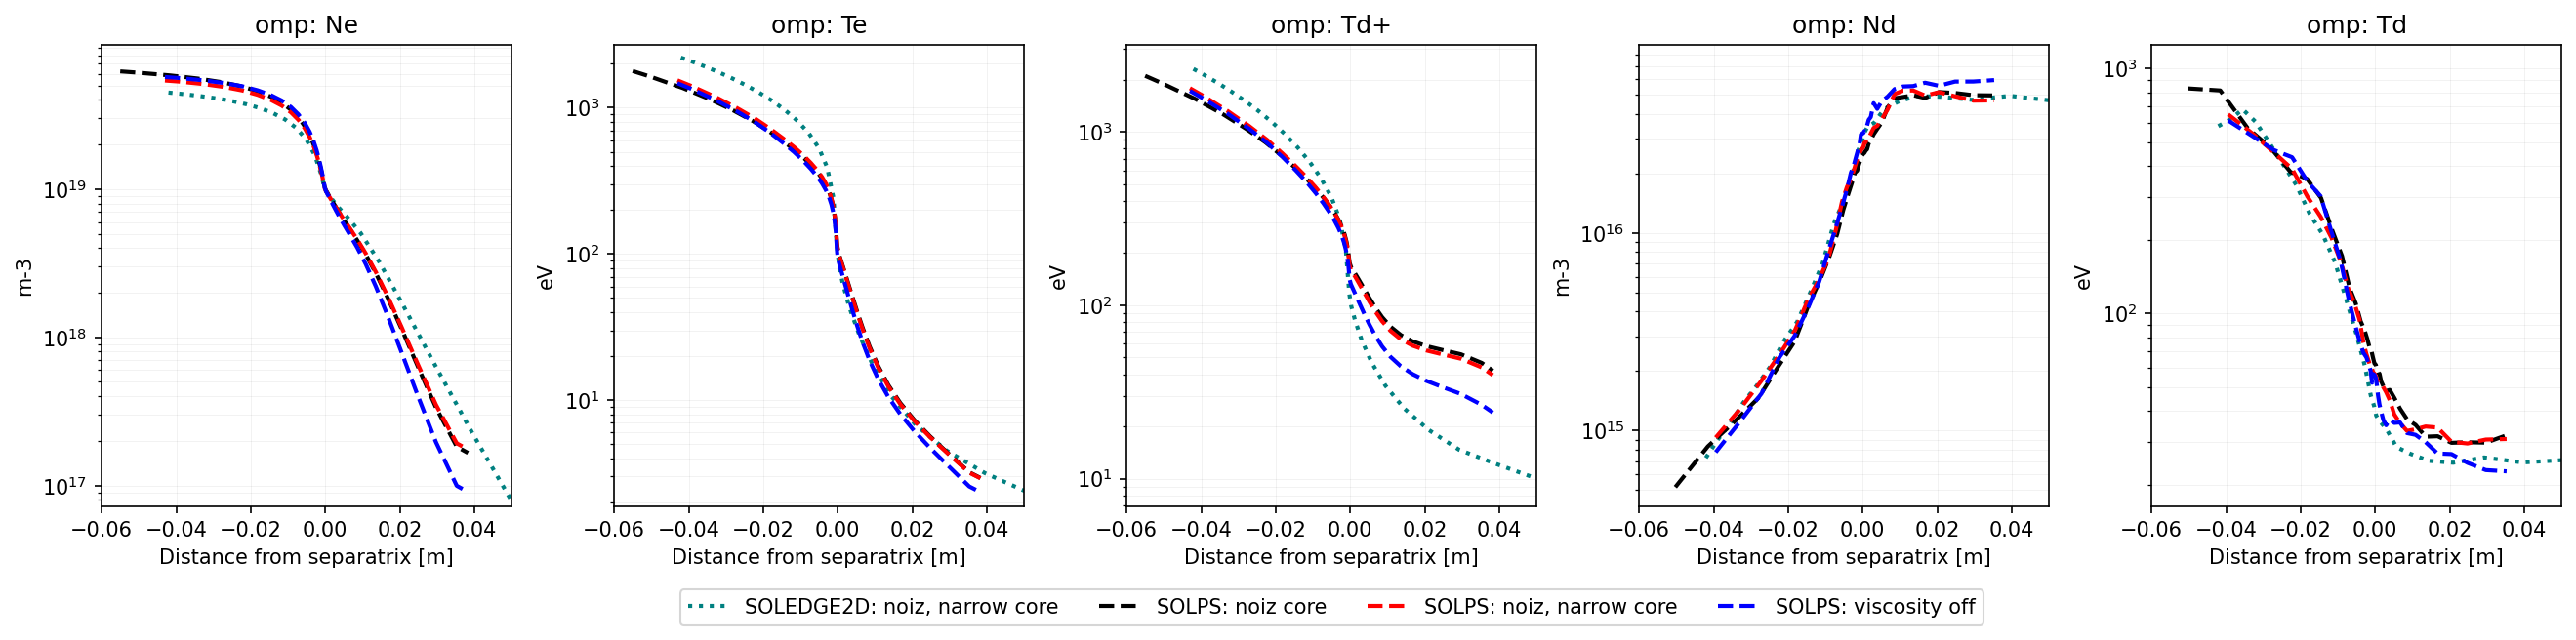

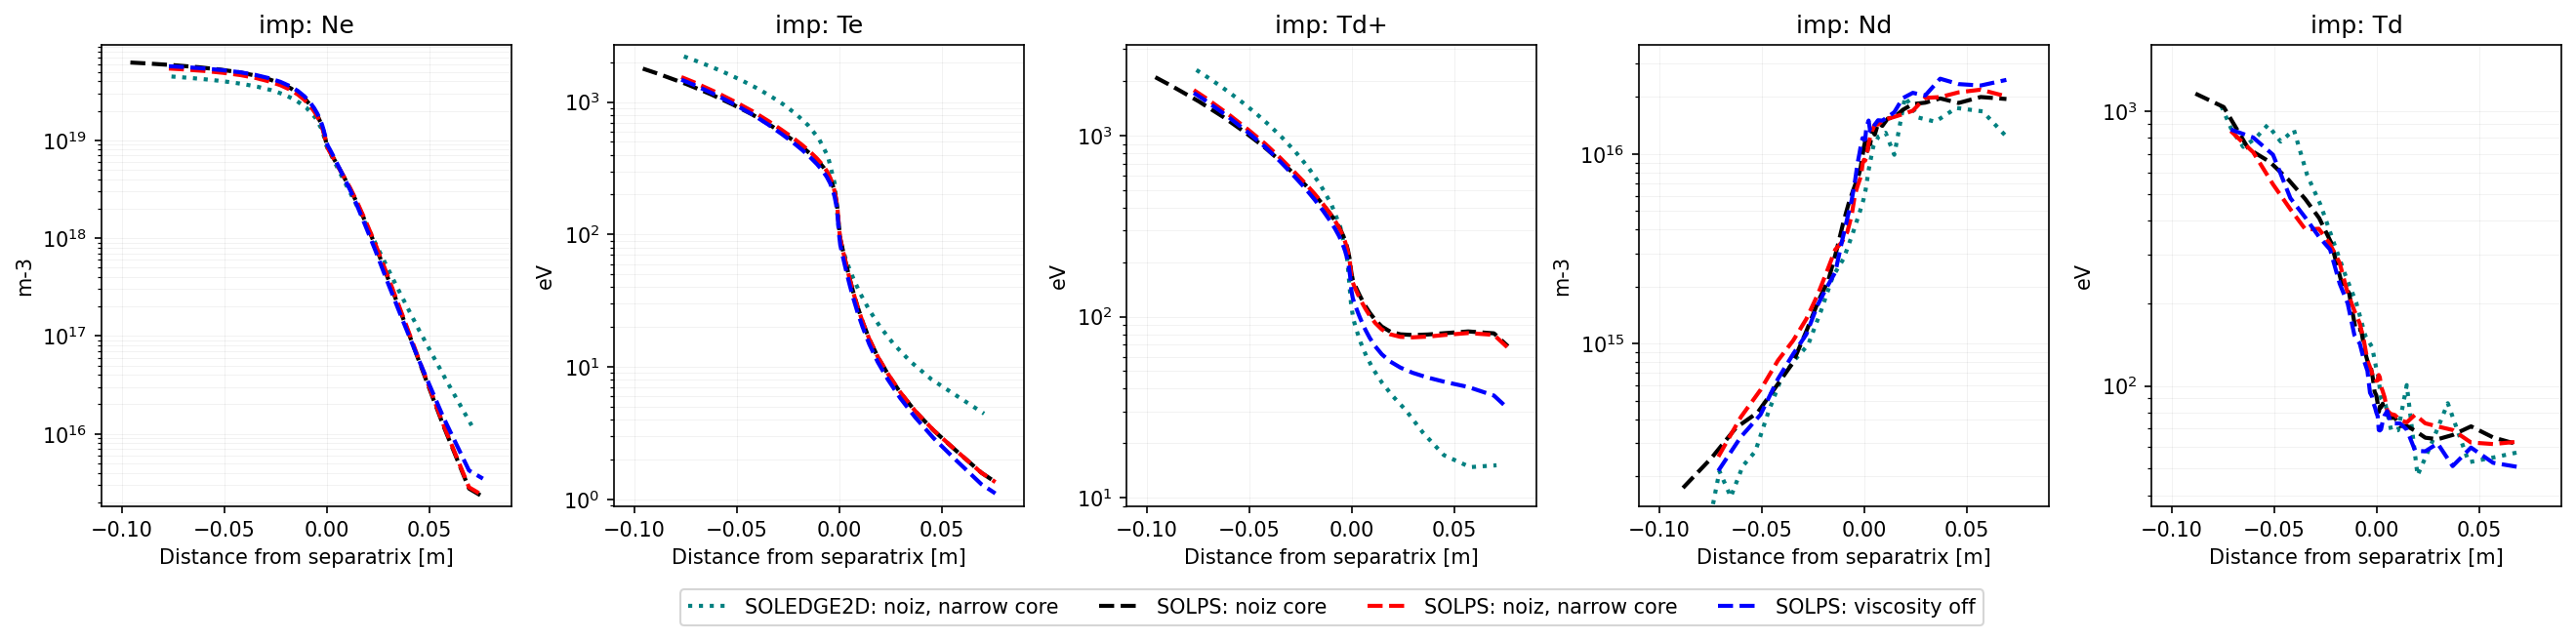

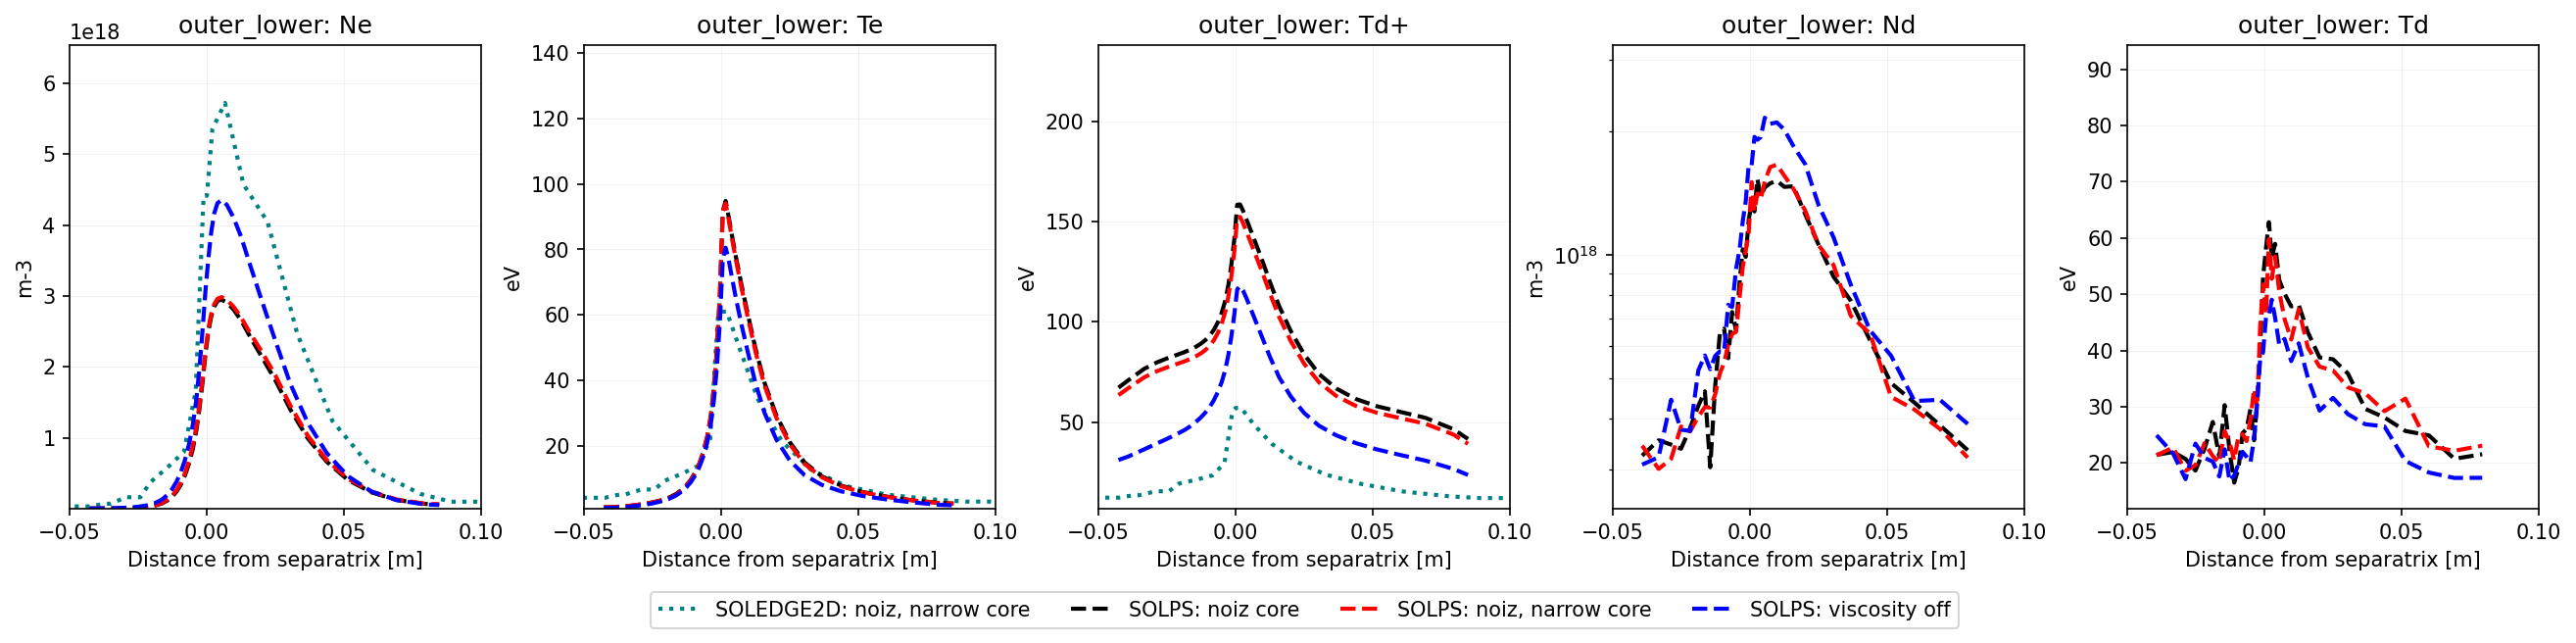

In [20]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    "SOLEDGE2D: noiz, narrow core": dict(data=sl["nocore_d"], color="teal"),
    "SOLPS: noiz core" : dict(data=sp["noiz_core"], color="black"),
    "SOLPS: noiz, narrow core" : dict(data=sp["narrow_core"], color="red"),
    "SOLPS: viscosity off" : dict(data=sp["no_visc"], color="blue"),
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

## Aligning Hermes-3

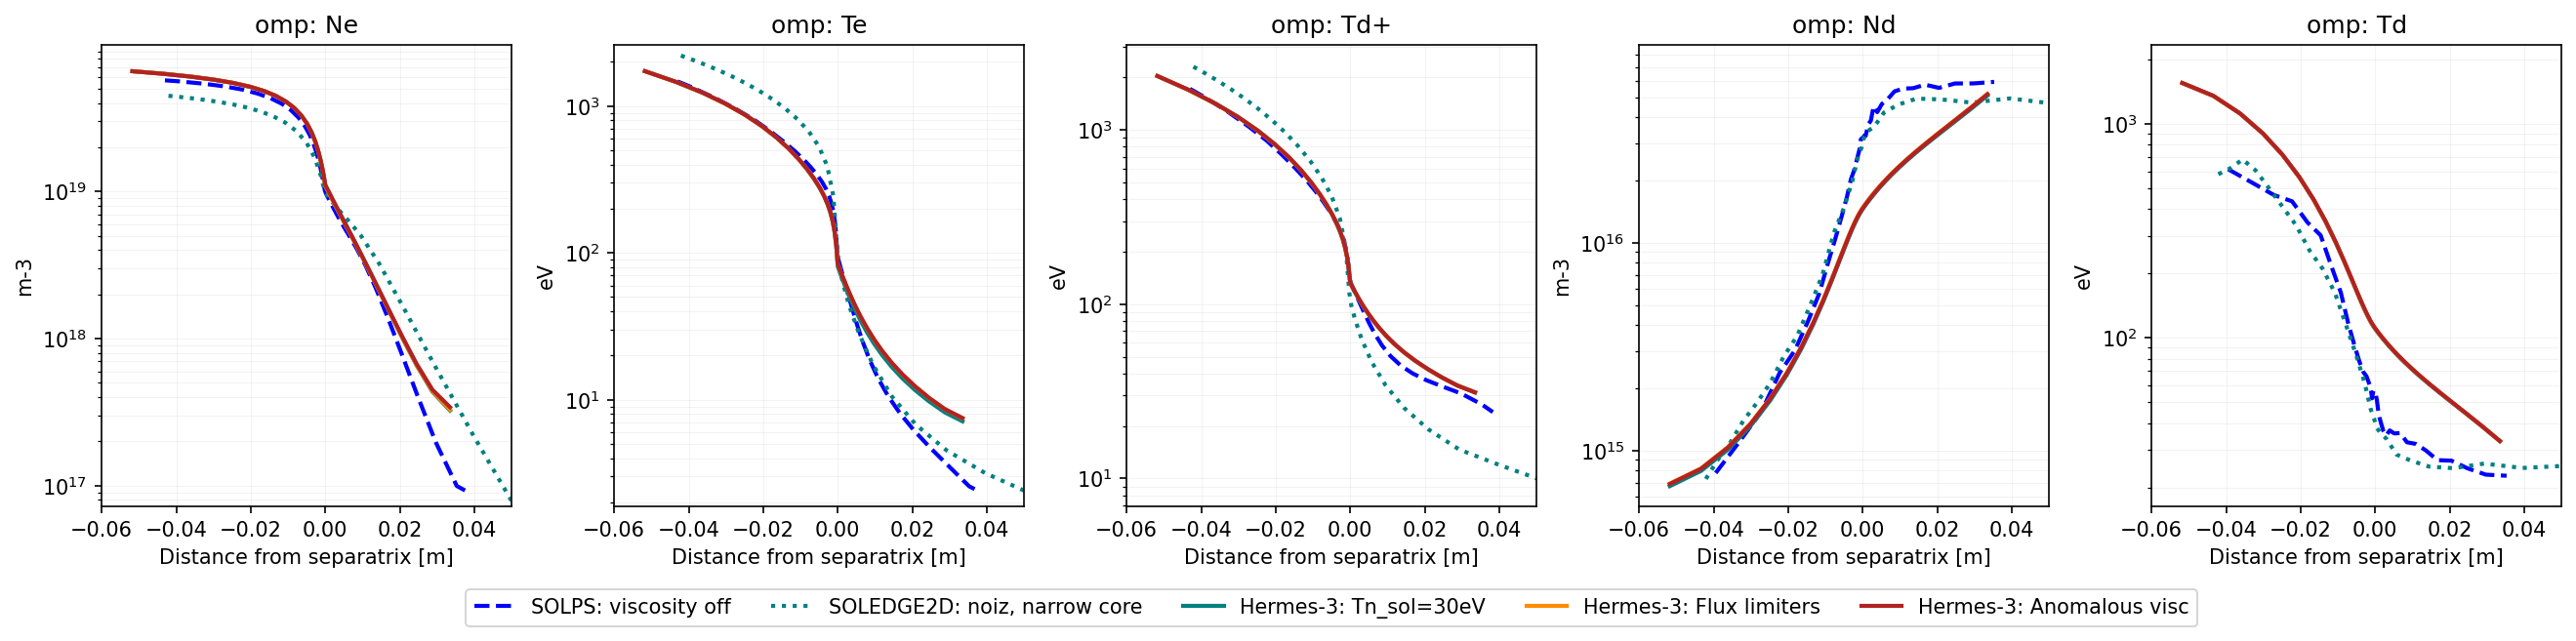

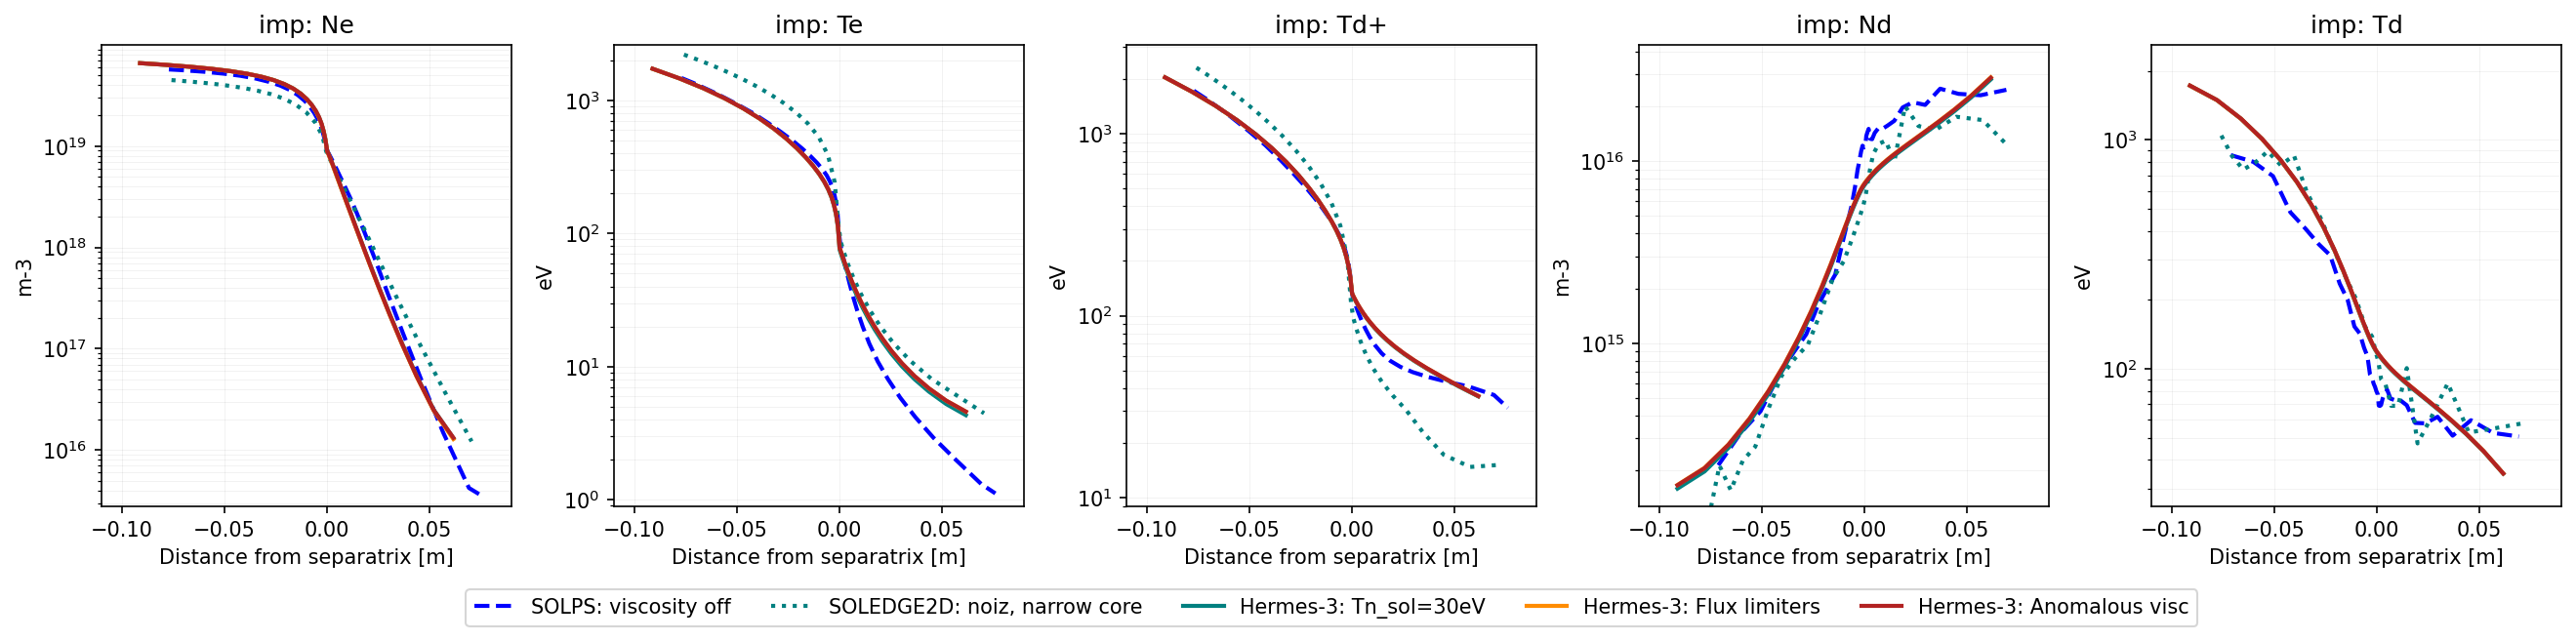

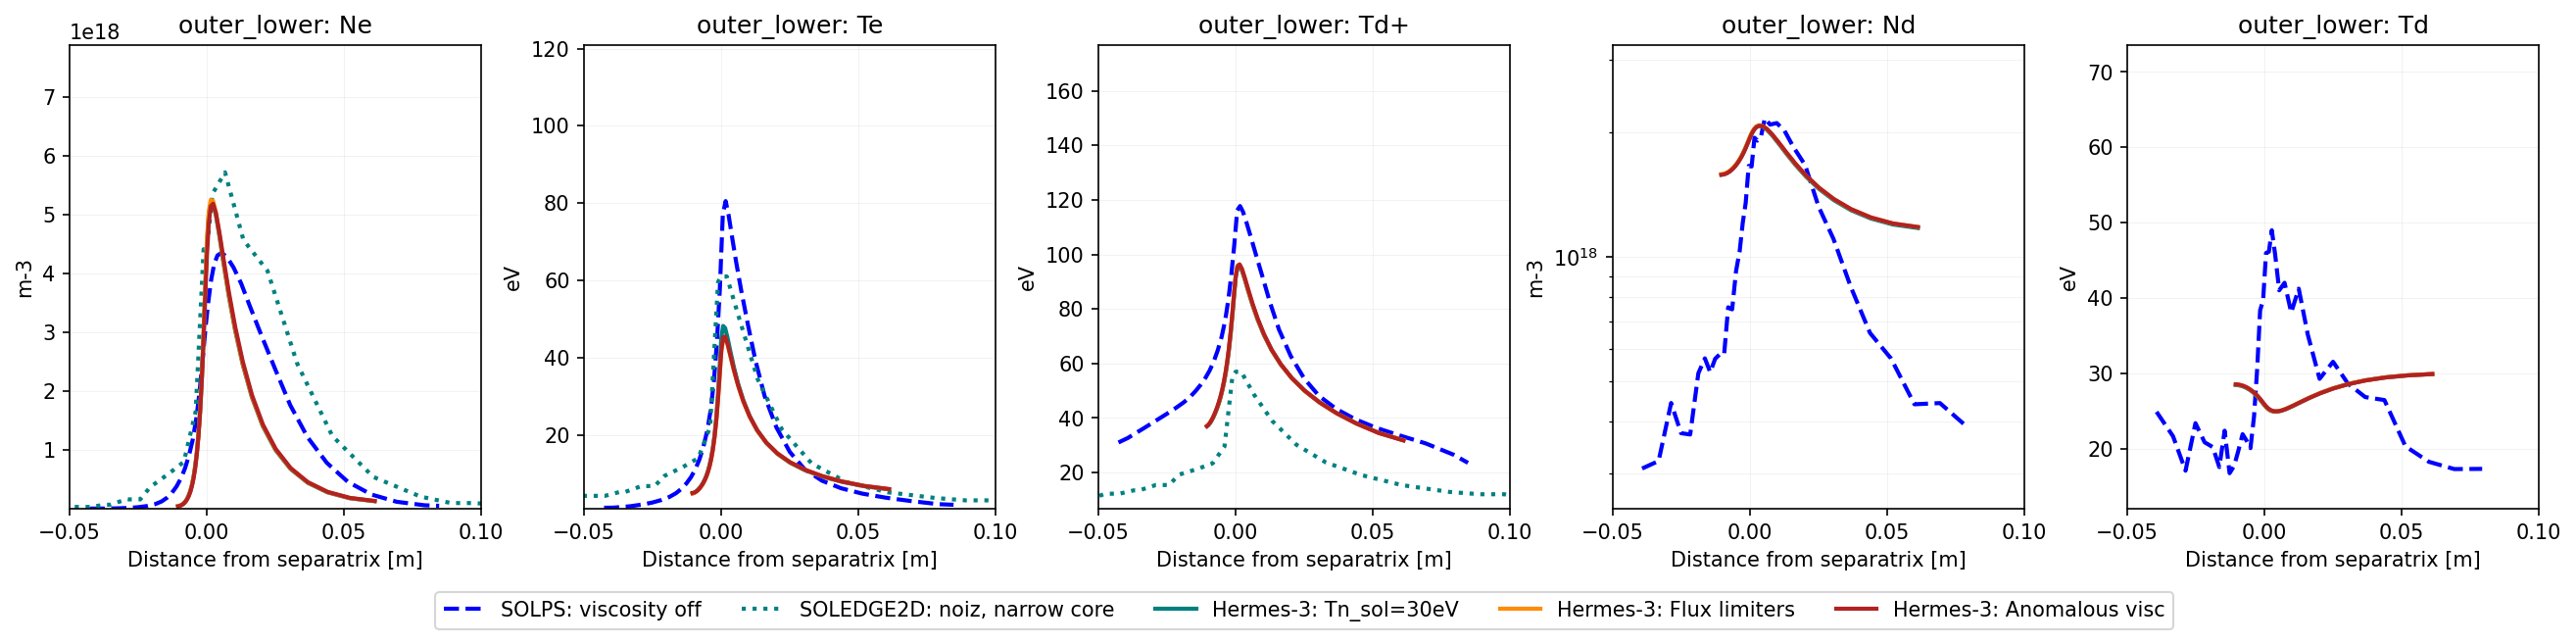

In [25]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    "SOLPS: viscosity off" : dict(data=sp["no_visc"], color="blue"),
    "SOLEDGE2D: noiz, narrow core": dict(data=sl["nocore_d"], color="teal"),

    "Hermes-3: Tn_sol=30eV" : dict(data=hr["base"], color="teal"),
    "Hermes-3: Flux limiters" : dict(data=hr["fluxlim"], color="darkorange"),
    "Hermes-3: Anomalous visc" : dict(data=hr["anom_visc"], color="firebrick"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    mode = "log",
    dpi = 150,
    lw = 2
)

## Higher density

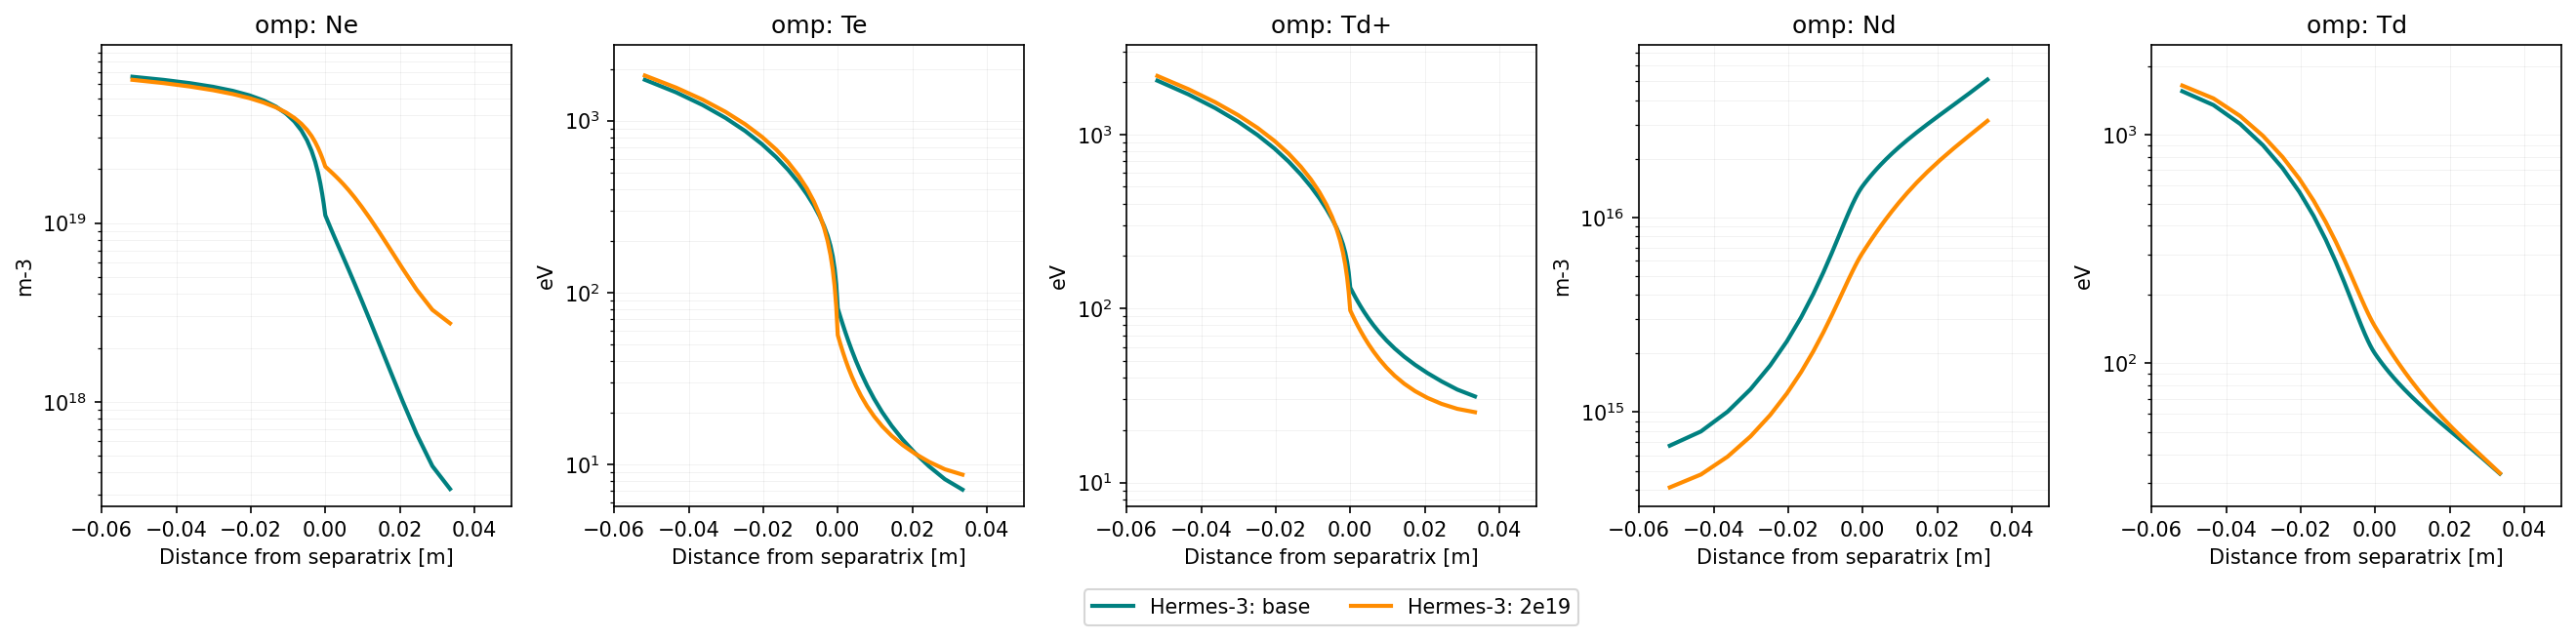

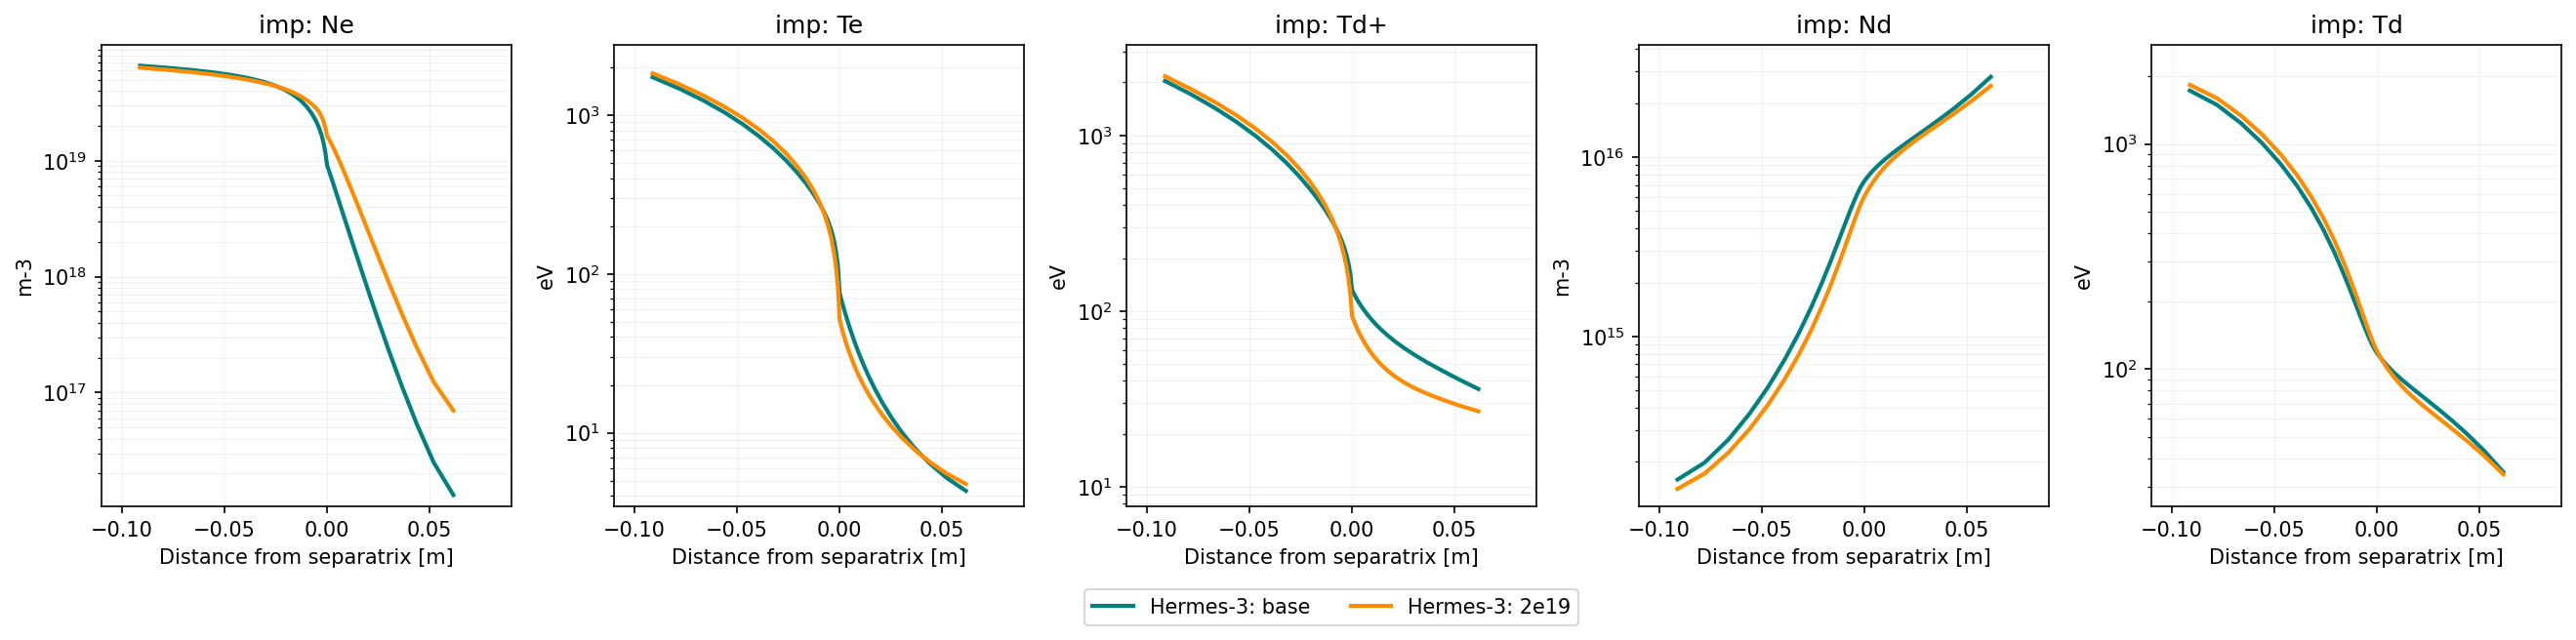

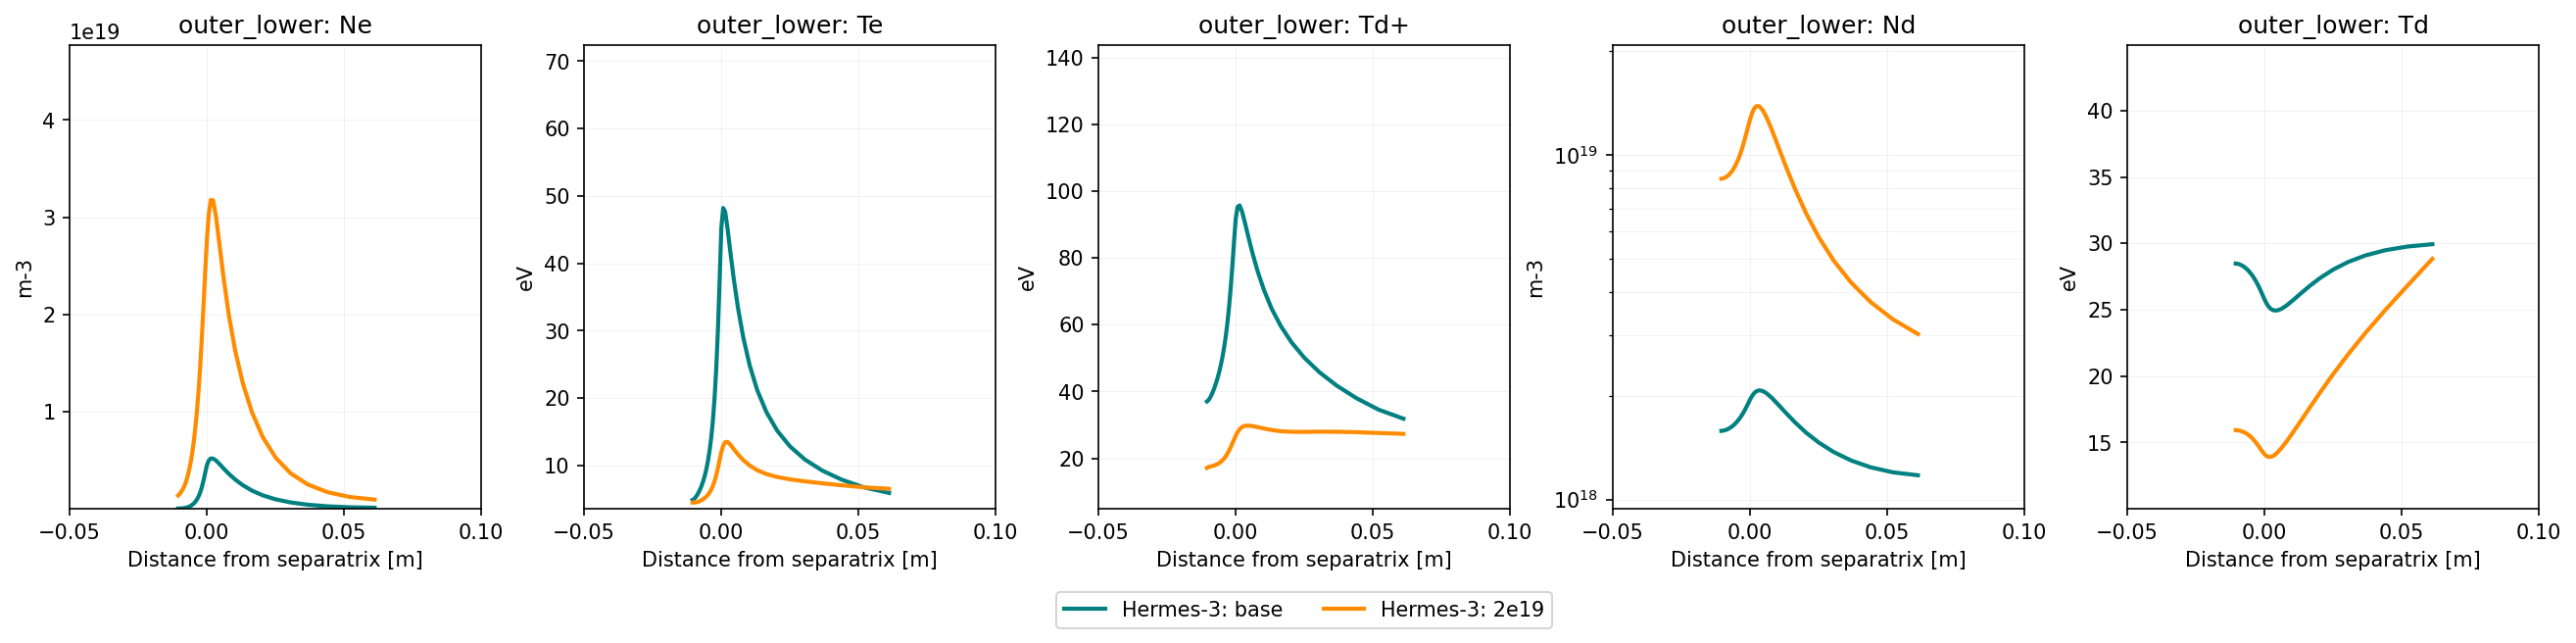

In [27]:

plt.close("all")
lineplot_compare(
    cases = { 
    "Hermes-3: base" : dict(data=hr["base"], color="teal"),
    "Hermes-3: 2e19" : dict(data=hr["2e19"], color="darkorange"),
    },
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    mode = "log",
    dpi = 150,
    lw = 2
)

# Comparing new grids

In [21]:
p1 = SOLEDGEplot(path = soledgecases["nocurr_base"], param = name_parser("Te", "soledge"))
p2 = SOLEDGEplot(path = soledgecases["nocore_d"], param = name_parser("Te", "soledge"))
p3 = SOLEDGEplot(path = soledgecases["tightwall"], param = name_parser("Te", "soledge"))

	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline/Results/plasma_0
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline/Results/plasma_1
load_soledge_mesh_file: reading file  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline\mesh.h5
	load_soledge_mesh_file: in_equ = OK
	h5_read: error reading:  /mesher/Fields/RadArroundXp
	load_soledge_mesh_file: extrapol = OK
	load_soledge_mesh_file: xPoints = OK
	load_soledge_mesh_file: Frontiers = OK
	load_soledge_mesh_file: Limits = OK
	h5_read: error reading:  /mesher/OMP_segment/mesher/refpoints/nPoints
	load_soledge_mesh_file: Segments = OK
	load_soledge_mesh_file: MagGrid_OK = OK
	load_soledge_mesh_file: new_equ = OK
	load_soledge_mesh_file: equ = OK
	load_soledge_mesh_file: Mesh = OK
	load_soledge_mesh_file: transp_prof = OK
	load_soledge_mesh_file: transp_values = O

## New extended grid

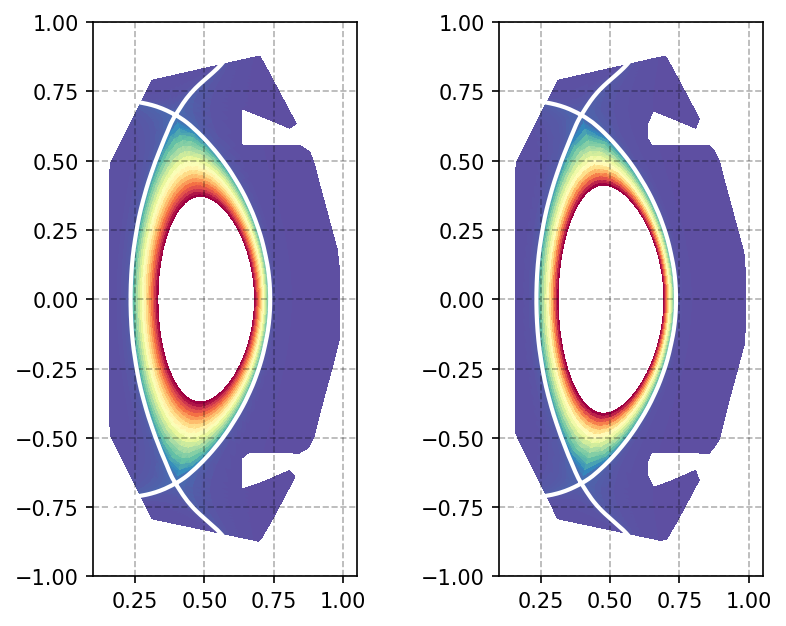

In [69]:
fig, axes = plt.subplots(1, 2, dpi = 150)

p1.plot(ax = axes[0], )
p2.plot(ax = axes[1])

for ax in axes:
    ax.set_ylim((-1,1))
    ax.set_xlim(0.1,1.05)
    ax.grid(color = "k", alpha = 0.3, ls = "--")

## New tight grid

In [28]:
solpscases.keys()

dict_keys(['base', 'noiz_core', 'gammai_2.5', 'dpuff_1e22', 'dpuff_5e21', 'no_fast_reflec', 'nsep_3e19', 'narrow_core', 'no_visc'])

	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_0
	load_plasma_files: Loading:  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D/Results/plasma_1
load_soledge_mesh_file: reading file  c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D\mesh.h5
	load_soledge_mesh_file: in_equ = OK
	h5_read: error reading:  /mesher/Fields/RadArroundXp
	load_soledge_mesh_file: extrapol = OK
	load_soledge_mesh_file: xPoints = OK
	load_soledge_mesh_file: Frontiers = OK
	load_soledge_mesh_file: Limits = OK
	h5_read: error reading:  /mesher/OMP_segment/mesher/refpoints/nPoints
	load_soledge_mesh_file: Segments = OK
	load_soledge_mesh_file: MagGrid_OK = OK
	load_soledge_mesh_file: new_equ = OK
	load_soledge_mesh_file: equ = OK
	load_soledge_mesh_file: Mesh = OK
	load_soledge_mesh_file: transp_prof = OK
	load_soledge_mesh_file:

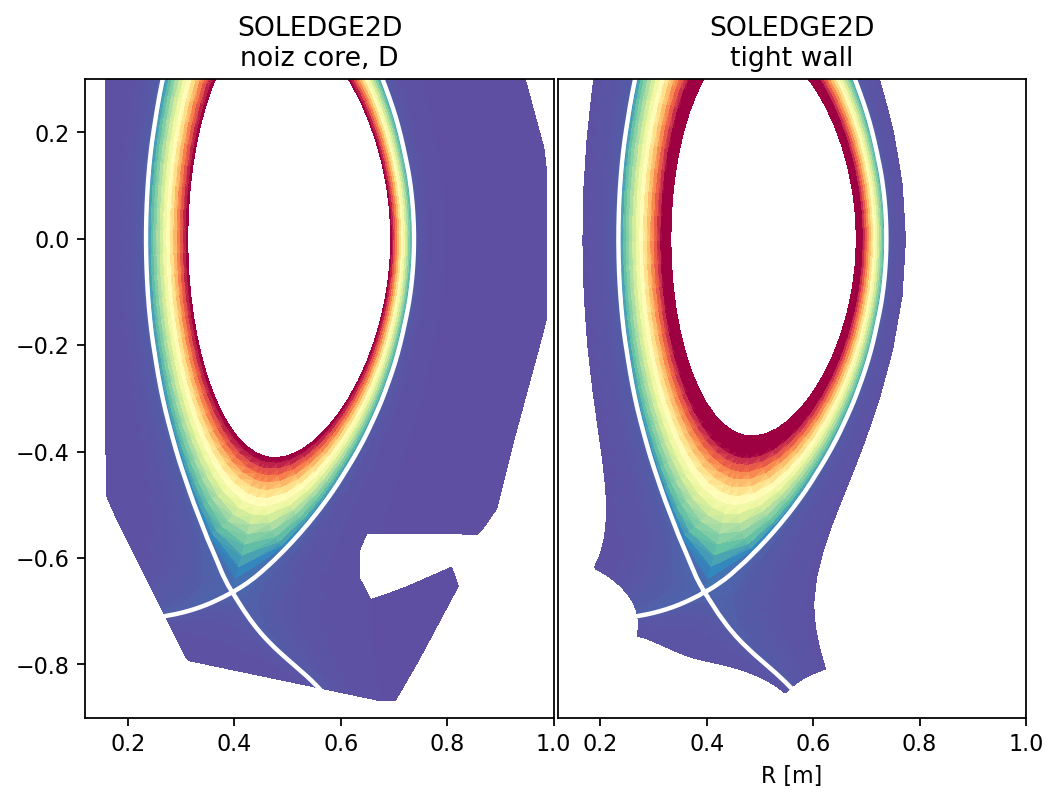

In [77]:
v = viewer_2d(
    "Te",
    {
        # "Case 1"  : {"code":"hermes", "ds" : casestore["fit"].ds.isel(t=-1)},
        # "Cooled N"  : {"code":"hermes", "ds" : casestore["n_cooling"].ds.isel(t=-1)},
        # "Baseline" : {"code":"soledge", "path" : soledgecases["nocurr_base"]},
        # "noiz core, D" : {"code":"soledge", "path" : soledgecases["nocore_d"]},
        # "tight wall" : {"code":"soledge", "path" : soledgecases["tightwall"]},
        "No viscosity" : {"code":"solps", "path" : solpscases["no_visc"]}
        # "Tn = 30eV" : {"code":"hermes", "ds" : caseng.ds.isel(t=-1)}
    },
    logscale = False,
    # vmin = 10,
    # vmax = 2000,
    # vmin = 1e17,
    # vmax = 5e17,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

# Recreate last10s

In [11]:
from gridtools.solps_python_scripts.utilities.last10s import read_last10s
import shutil
# from gridtools.solps_python_scripts.reactions.compute_rates import compute_rates

directory = os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent")

for folder in os.listdir(directory):
    if "HERMES_SOLEDGE" in folder:
        print(folder)
        casepath = os.path.join(directory,folder)
        if "last10s.pkl" in os.listdir(casepath):
            os.remove(os.path.join(casepath, "last10s.pkl"))
        last10s = read_last10s(where = casepath, save = True)

# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_hydrogen\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"
# x = read_last10s(where = path, save = True)


HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates ...
b2fgmtry loaded from .pkl
b2fstate loaded from .pkl
fort.44 loaded from .pkl
fort.46 loaded from .pkl
read_all_reactions - reactions.pkl

  H.0, H.1, H.10 not yet implemented!

  Species H_2(X^1\Sigma_g^+) switch not implemented!

  Species H_2(X^1\Sigma_g^+) switch not implemented!

  Species H_2(X^1\Sigma_g^+) switch not implemented!

  H.0, H.1, H.10 not yet implemented!

  H.0, H.1, H.10 not yet implemented!

  H.0, H.1, H.10 not yet implemented!
HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0
read_last10s
fort.44 loaded from .pkl
b2fgmtry loaded from .pkl
compute_rates ...
b2fgmtry loaded from .pkl
b2fstate loaded from .pkl
fort.44 loaded from .pkl
fort.46 load